In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer, RobertaModel
import torch
from tqdm import tqdm

# Load data
data = pd.read_csv('/net/scratch2/chenxi/MPCS-python/data/final_mfrc_data.csv')

/home/chenxi3/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Preview dataset
print("Dataset preview:")
data.head()

Dataset preview:


,text,subreddit,bucket,annotator,annotation,confidence
0,That particular part of the debate is especial...,europe,French politics,annotator03,Non-Moral,Confident
1,That particular part of the debate is especial...,europe,French politics,annotator01,Purity,Confident
2,That particular part of the debate is especial...,europe,French politics,annotator02,Thin Morality,Confident
3,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator03,Non-Moral,Confident
4,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator00,Non-Moral,Somewhat Confident


In [3]:
# Unify labels according to rules
def unify_labels(annotation_set):
    unified = set()
    for label in annotation_set:
        if label == "Purity":
            unified.add("Sanctity")
        elif label in {"Equality", "Proportionality"}:
            unified.add("Fairness")
        else:
            unified.add(label)
    return unified

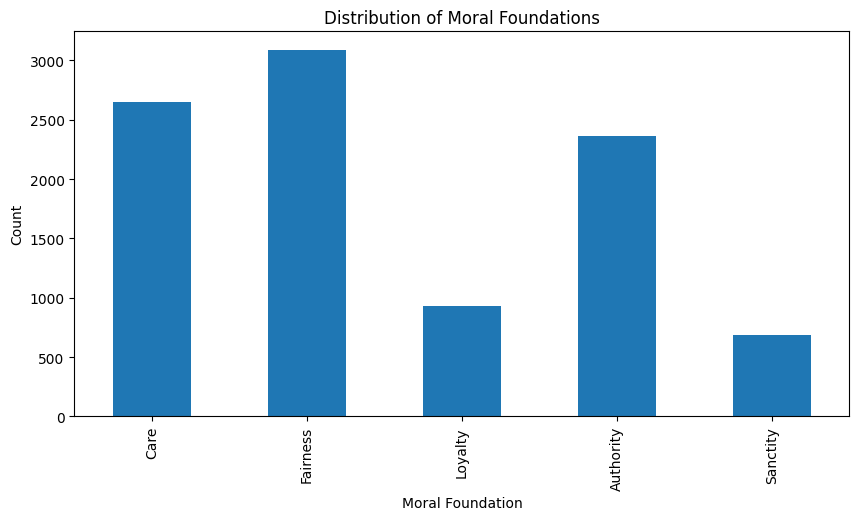

In [4]:
# Aggregate annotations per unique comment (text)
aggregated_data = data.groupby('text')['annotation'].apply(set).reset_index()

# Apply label unification
aggregated_data['unified_annotations'] = aggregated_data['annotation'].apply(unify_labels)

# Create binary classification labels for each foundation
foundations = ["Care", "Fairness", "Loyalty", "Authority", "Sanctity"]
for foundation in foundations:
    aggregated_data[foundation] = aggregated_data['unified_annotations'].apply(lambda x: 1 if foundation in x else 0)

# Display the resulting dataframe
aggregated_data.head()

# Drop rows with missing text
data_clean = aggregated_data.dropna(subset=['text'])

# Simple EDA
plt.figure(figsize=(10, 5))
data_clean[foundations].sum().plot(kind='bar')
plt.title('Distribution of Moral Foundations')
plt.xlabel('Moral Foundation')
plt.ylabel('Count')
plt.show()


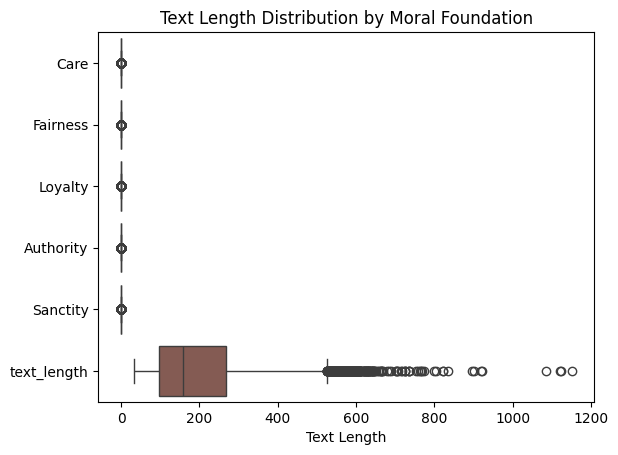

In [5]:
# Text length analysis
data_clean['text_length'] = data_clean['text'].apply(len)
sns.boxplot(data=data_clean[foundations + ['text_length']], orient='h')
plt.title('Text Length Distribution by Moral Foundation')
plt.xlabel('Text Length')
plt.show()

# Prepare data for modeling
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(data_clean['text'])

In [6]:
# Train and evaluate models for each foundation
for foundation in foundations:
    print(f"\nModeling for {foundation}")
    y = data_clean[foundation]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Random Forest Model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    rf_auc = roc_auc_score(y_test, rf_preds)
    print(f"Random Forest AUC for {foundation}: {rf_auc:.3f}")

    # Logistic Regression Model
    lr_model = LogisticRegression(max_iter=500)
    lr_model.fit(X_train, y_train)
    lr_preds = lr_model.predict(X_test)
    lr_auc = roc_auc_score(y_test, lr_preds)
    print(f"Logistic Regression AUC for {foundation}: {lr_auc:.3f}")


Modeling for Care
Random Forest AUC for Care: 0.560
Logistic Regression AUC for Care: 0.571

Modeling for Fairness
Random Forest AUC for Fairness: 0.577
Logistic Regression AUC for Fairness: 0.557

Modeling for Loyalty
Random Forest AUC for Loyalty: 0.543
Logistic Regression AUC for Loyalty: 0.502

Modeling for Authority
Random Forest AUC for Authority: 0.520
Logistic Regression AUC for Authority: 0.517

Modeling for Sanctity
Random Forest AUC for Sanctity: 0.535
Logistic Regression AUC for Sanctity: 0.507


In [7]:
# Initialize RoBERTa tokenizer and model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name).to(device)

# Function to generate RoBERTa embeddings on GPU
def get_roberta_embeddings(texts):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
            outputs = model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            embeddings.append(embedding)
    return np.array(embeddings)

# Generate embeddings
X_embeddings = get_roberta_embeddings(data_clean['text'].tolist())

# Train and evaluate models for each foundation
for foundation in foundations:
    print(f"\nModeling for {foundation}")
    y = data_clean[foundation].values
    X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.3, random_state=42, stratify=y)

    # Random Forest Model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    rf_auc = roc_auc_score(y_test, rf_preds)
    print(f"Random Forest AUC for {foundation}: {rf_auc:.3f}")

    # Logistic Regression Model
    lr_model = LogisticRegression(max_iter=500)
    lr_model.fit(X_train, y_train)
    lr_preds = lr_model.predict(X_test)
    lr_auc = roc_auc_score(y_test, lr_preds)
    print(f"Logistic Regression AUC for {foundation}: {lr_auc:.3f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Modeling for Care
Random Forest AUC for Care: 0.538


/net/projects/chai-lab/miniconda3/envs/llava_chenxi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC for Care: 0.661

Modeling for Fairness
Random Forest AUC for Fairness: 0.507


/net/projects/chai-lab/miniconda3/envs/llava_chenxi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC for Fairness: 0.599

Modeling for Loyalty
Random Forest AUC for Loyalty: 0.500


/net/projects/chai-lab/miniconda3/envs/llava_chenxi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC for Loyalty: 0.522

Modeling for Authority
Random Forest AUC for Authority: 0.500


/net/projects/chai-lab/miniconda3/envs/llava_chenxi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC for Authority: 0.569

Modeling for Sanctity
Random Forest AUC for Sanctity: 0.500
Logistic Regression AUC for Sanctity: 0.533
